# Hyperparameter Tuning for Random Forest Classifier (One vs. All)

In [1]:
# import libraries
import os
import json
import requests
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set_theme(style="whitegrid")

In [2]:
# import data
df = pd.read_csv('data/tracks_1000+.csv', index_col=False)
df.drop(columns={'Unnamed: 0'}, inplace=True)

In [3]:
del df["track_id"]; del df["artist_name"]; del df["track_name"]

In [4]:
# Make it 1000 for each category
result = df.groupby("genre").apply(lambda x: x.head(1000)).reset_index(drop=True)
result

,popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
1,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
2,86,blues,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.2780,123.596,232107,4
3,80,blues,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.2730,113.980,208760,4
4,80,blues,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.2730,113.980,208760,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,37,techno,0.714,0.621,9,-7.005,1,0.0893,0.20100,0.0192,0.0568,0.7450,114.237,331040,4
9996,34,techno,0.803,0.960,9,-3.342,0,0.0429,0.01570,0.0242,0.0566,0.5470,125.990,231271,4
9997,49,techno,0.880,0.477,0,-10.947,1,0.0732,0.00143,0.6270,0.0922,0.2090,125.017,539520,4
9998,47,techno,0.626,0.665,7,-10.134,0,0.0574,0.00775,0.7560,0.0811,0.0327,125.009,240000,4


## Training Preparation & Scaling

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y_tmp = pd.DataFrame(result["genre"])
X = result.drop("genre", axis=1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_tmp)
cols = [x.replace("x0_", "") for x in encoder.get_feature_names()]
display(len(cols))
y = pd.DataFrame(encoder.transform(y_tmp), columns=cols)
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)# , stratify=y > 0

10

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

def scaler_pipeline():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler())

def scaler_pipeline_pwr():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler(), PowerTransformer(method='yeo-johnson', standardize=True))

ct = ColumnTransformer([
        ('stdscaled', StandardScaler(), ["popularity","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms","time_signature"]),
       ], remainder='passthrough')

X_train_scaled = ct.fit_transform(X_train_org)
X_test_scaled  = ct.transform(X_test_org)
X_train = X_train_scaled
X_test  = X_test_scaled

## Examine Parameters and Influences

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Number of Trees in Forest

In [16]:
n_trees = [10, 50, 100, 500, 1000]
cv_scores = {
    'genre': [],
    'n_trees': [],
    'score': []
}

for gen in y_train.columns:
    print('Genre:\t', gen)
    for n_estimator in n_trees:
        _model = RandomForestClassifier(n_estimator)
        _model.fit(X_train, y_train[gen])
        cv = cross_val_score(_model, X_train, y_train[gen], cv=3, scoring='accuracy')
        print('Cross validation score for {} estimator -> \t {}'.format(n_estimator, cv))
        cv_scores['genre'].append(gen)
        cv_scores['n_trees'].append(n_estimator)
        cv_scores['score'].append(cv)
    print('')

cv_scores_df = pd.DataFrame.from_dict(cv_scores)

Genre:	 blues
Cross validation score for 10 estimator -> 	 [0.88938883 0.90026247 0.89647412]
Cross validation score for 50 estimator -> 	 [0.90101237 0.90326209 0.90097524]
Cross validation score for 100 estimator -> 	 [0.89726284 0.90251219 0.89984996]
Cross validation score for 500 estimator -> 	 [0.89876265 0.90138733 0.90060015]
Cross validation score for 1000 estimator -> 	 [0.89801275 0.90251219 0.89984996]

Genre:	 classical
Cross validation score for 10 estimator -> 	 [0.98950131 0.98687664 0.98762191]
Cross validation score for 50 estimator -> 	 [0.98987627 0.98987627 0.99024756]
Cross validation score for 100 estimator -> 	 [0.99100112 0.98912636 0.98912228]
Cross validation score for 500 estimator -> 	 [0.98987627 0.98950131 0.98987247]
Cross validation score for 1000 estimator -> 	 [0.99100112 0.98912636 0.98987247]

Genre:	 electronic
Cross validation score for 10 estimator -> 	 [0.90813648 0.9103862  0.90435109]
Cross validation score for 50 estimator -> 	 [0.91301087 0.

In [18]:
def plot_validations(cv_scores, x_label, x_ticklabels, genre):
    plt.figure(figsize=(len(x_ticklabels),4))
    plt.title(genre)
    ax = sns.boxplot(data=cv_scores)
    ax.set_xticklabels(x_ticklabels)
    ax.set_ylabel('accuracy')
    ax.set_xlabel(x_label);

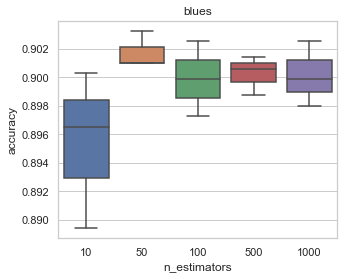

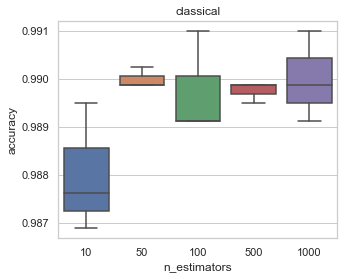

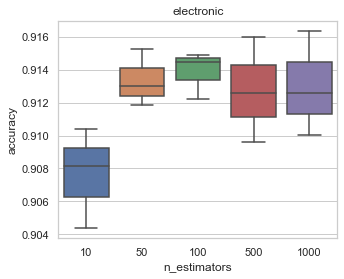

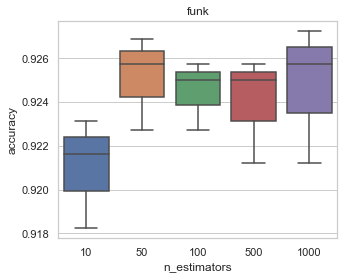

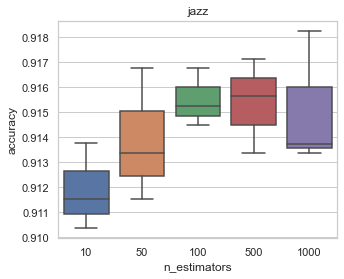

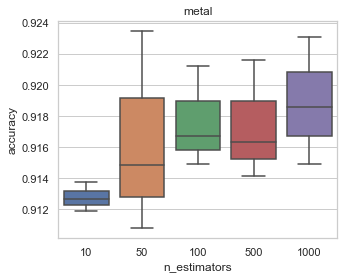

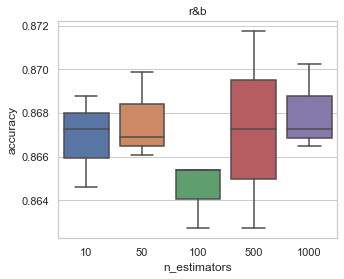

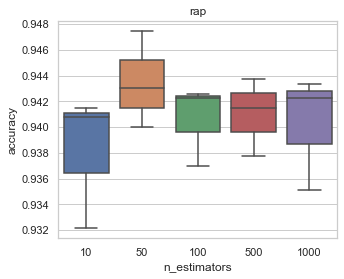

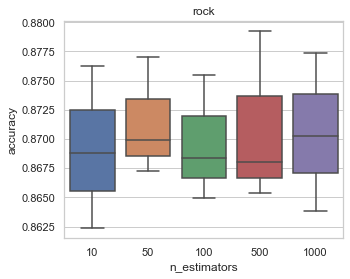

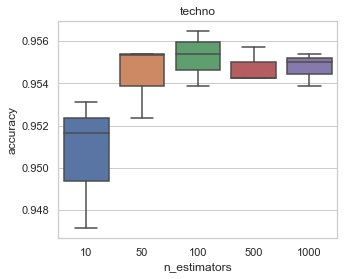

In [19]:
for genre in y_train.columns:
    plot_validations(cv_scores_df[cv_scores_df['genre']==genre]['score'].tolist(), 'n_estimators', n_trees, genre)

### Max Tree Depth

In [20]:
max_depths = range(1,8)

cv_scores_max_depth = {
    'genre': [],
    'tree_depth': [],
    'score': []
}

for genre in y_train.columns:
    print('Genre:\t', genre)
    for depth in max_depths:
        _model = RandomForestClassifier(max_depth=depth)
        _model.fit(X_train, y_train[genre])
        cv = cross_val_score(_model, X_train, y_train[genre], cv=3, scoring='accuracy')
        print('Cross validation score for max tree depth of {} -> \t {}'.format(depth, cv))
        cv_scores_max_depth['genre'].append(genre)
        cv_scores_max_depth['tree_depth'].append(depth)
        cv_scores_max_depth['score'].append(cv)
    print('')

cv_scores_max_depth_df = pd.DataFrame.from_dict(cv_scores_max_depth)

Genre:	 blues
Cross validation score for tree depth of 1 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for tree depth of 2 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for tree depth of 3 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for tree depth of 4 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for tree depth of 5 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for tree depth of 6 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for tree depth of 7 -> 	 [0.90026247 0.90101237 0.90060015]

Genre:	 classical
Cross validation score for tree depth of 1 -> 	 [0.95875516 0.94525684 0.9579895 ]
Cross validation score for tree depth of 2 -> 	 [0.97150356 0.97450319 0.975994  ]
Cross validation score for tree depth of 3 -> 	 [0.97975253 0.97937758 0.98237059]
Cross validation score for tree depth of 4 -> 	 [0.98612673 0.98350206 0.98537134]
Cross validation score for tree depth of 5 -> 	 [0.988

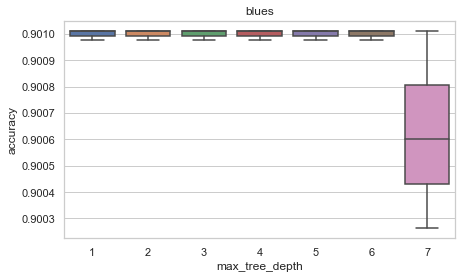

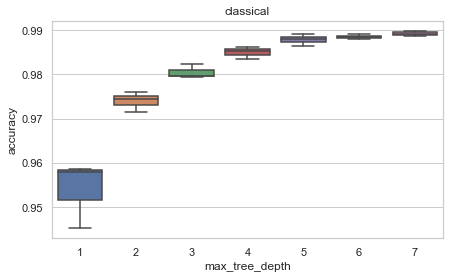

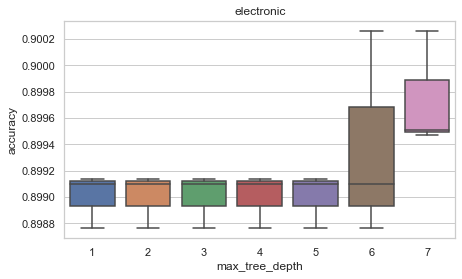

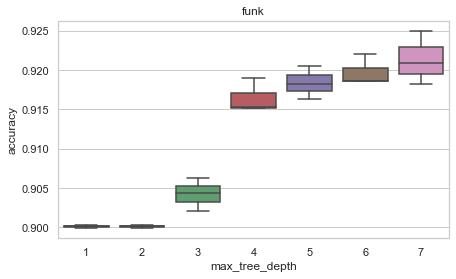

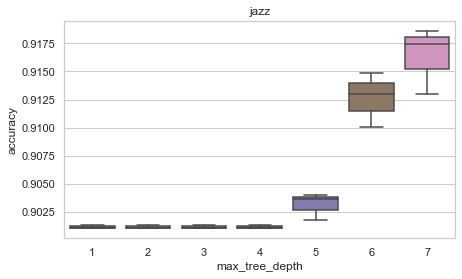

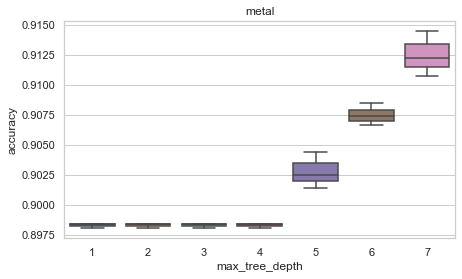

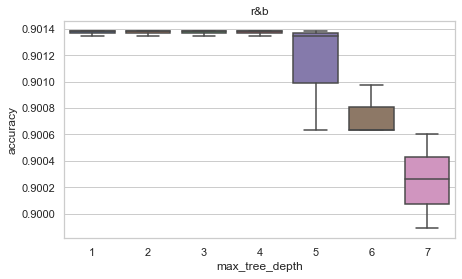

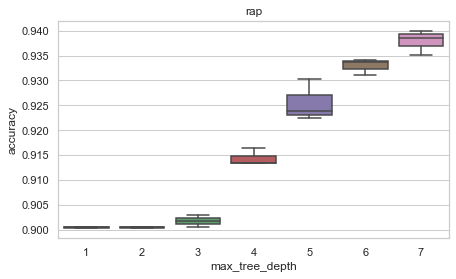

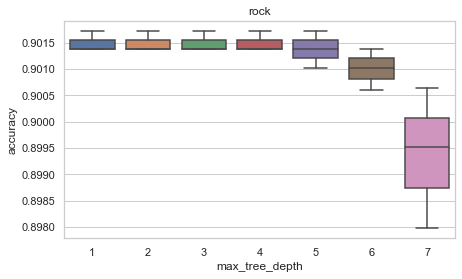

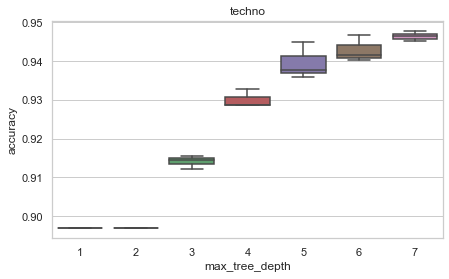

In [27]:
for genre in y_train.columns:
    plot_validations(cv_scores_max_depth_df[cv_scores_max_depth_df['genre']==genre]['score'].tolist(), 'max_tree_depth', max_depths, genre)

### Max Features in Model

In [34]:
n_max_features = range(1, X.shape[1])
cv_scores_max_features = {
    'genre': [],
    'n_features': [],
    'score': []
}

for genre in y_train.columns:
    print('Genre:\t', genre)
    for n_features in n_max_features:
        _model = RandomForestClassifier(max_features=n_features)
        _model.fit(X_train, y_train[genre])
        cv = cross_val_score(_model, X_train, y_train[genre], cv=3, scoring='accuracy')
        print('Cross validation score for max number of features {} -> \t {}'.format(n_features, cv))
        cv_scores_max_features['genre'].append(genre)
        cv_scores_max_features['n_features'].append(n_features)
        cv_scores_max_features['score'].append(cv)

cv_scores_max_features_df = pd.DataFrame.from_dict(cv_scores_max_features)

Genre:	 blues
Cross validation score for max number of features 1 -> 	 [0.89013873 0.89688789 0.89347337]
Cross validation score for max number of features 2 -> 	 [0.89501312 0.90026247 0.8975994 ]
Cross validation score for max number of features 3 -> 	 [0.89876265 0.90363705 0.90247562]
Cross validation score for max number of features 4 -> 	 [0.89688789 0.9047619  0.9036009 ]
Cross validation score for max number of features 5 -> 	 [0.90101237 0.90663667 0.90510128]
Cross validation score for max number of features 6 -> 	 [0.90213723 0.91076115 0.90435109]
Cross validation score for max number of features 7 -> 	 [0.90138733 0.90813648 0.90660165]
Cross validation score for max number of features 8 -> 	 [0.89951256 0.9103862  0.90547637]
Cross validation score for max number of features 9 -> 	 [0.90138733 0.90926134 0.90660165]
Cross validation score for max number of features 10 -> 	 [0.8976378  0.90851144 0.90735184]
Cross validation score for max number of features 11 -> 	 [0.8995

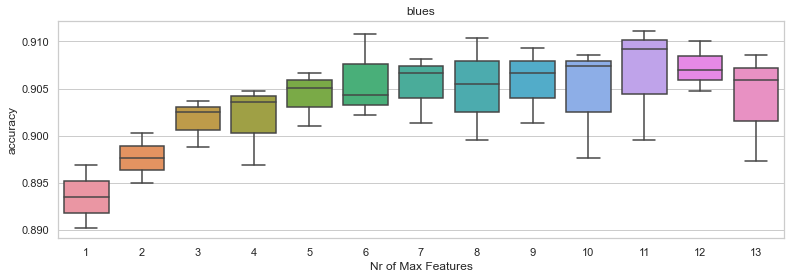

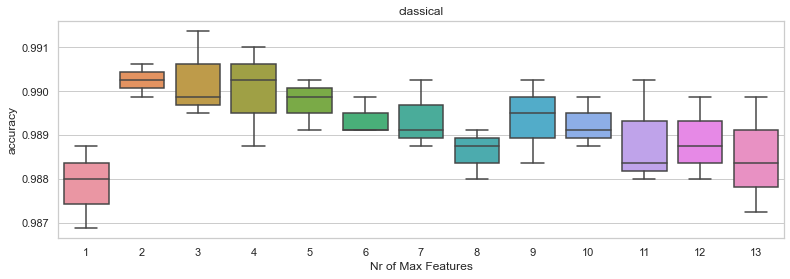

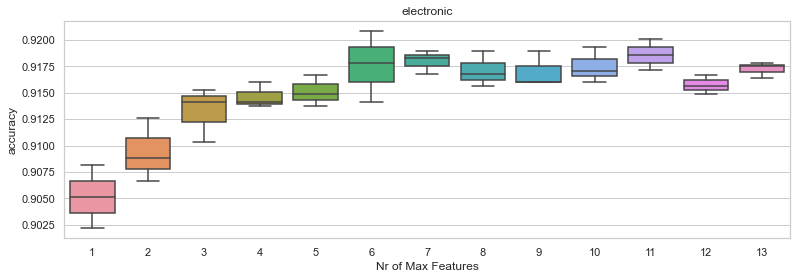

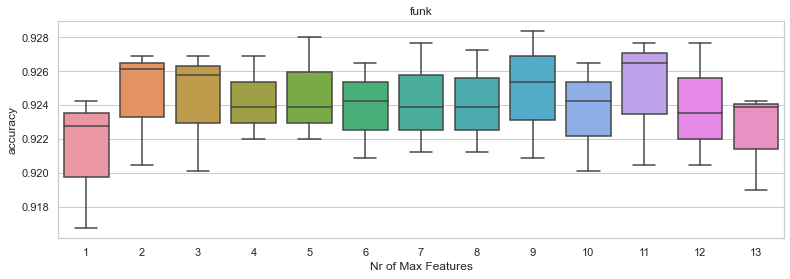

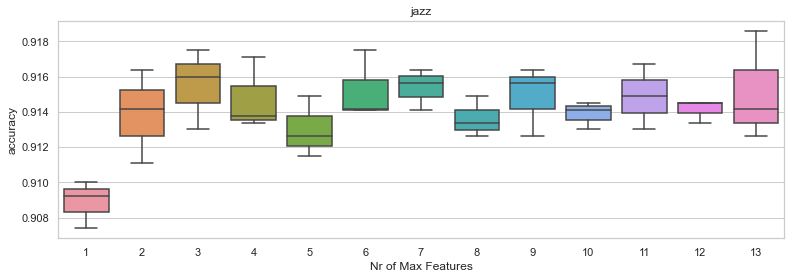

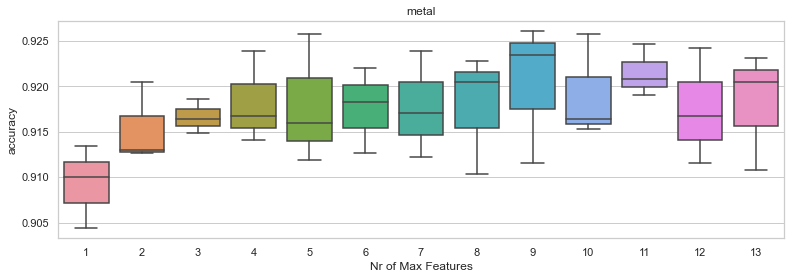

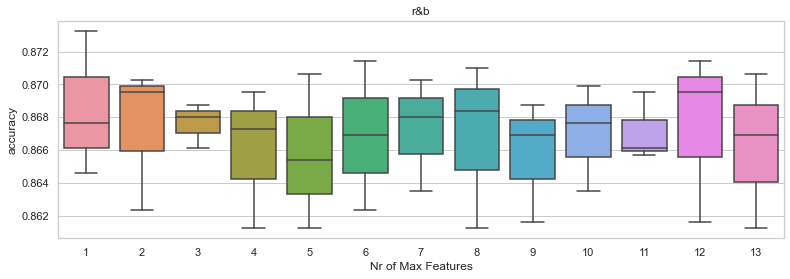

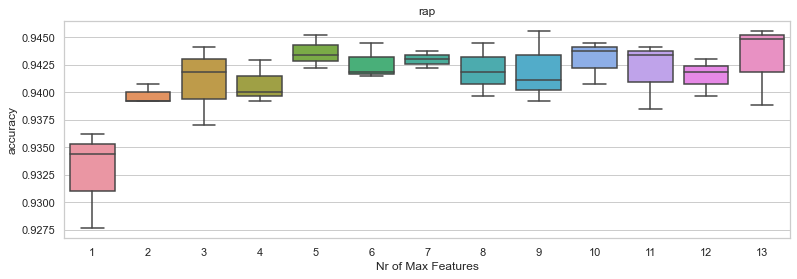

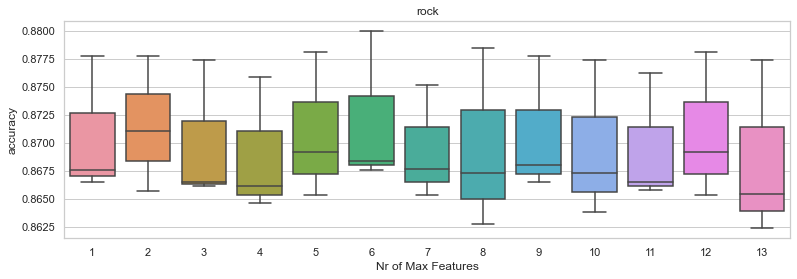

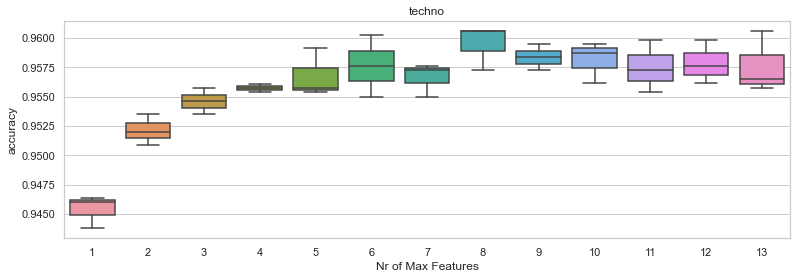

In [35]:
for genre in y_train.columns:
    plot_validations(cv_scores_max_features_df[cv_scores_max_features_df['genre']==genre]['score'].tolist(), 'Nr of Max Features', n_max_features, genre)

### Optimize parameters of random forest classifier